# Sound Recongnization Deep Learning Network Based on Tensorflow 1.0

--Robert.wei

We are trying to develop a whole new alarm system which will sound the alarm if the water leak is detected, however, the challenge is,  in everyday life, there's thounsand, maybe millions of sound around us. So this project aimed at developing a artifical intelligence system (aka. deep learing model) which can quickly indentify and alert the system when the specific alarm sound is on.


### DataSet:

.Sample Aalarm Sound video

### Tools used:

.Tensorflow

.Librosa

.Numpy

.Matplotlib

.skilearn



## 1.0 Data observation

In this dataset, the original video is modified to sound files in .wav format, if you have files in another format such as .mp3, then it’s good to convert them into .wav format. It’s because .mp3 is lossy music compression technique. 

In [1]:
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
import pandas as pd
import glob 

data, sampling_rate = librosa.load('/Users/dx/Documents/TF_sound_project/sample.wav')
print('The sampling rate is :' + str(sampling_rate))
#ipd.Audio('../sample.wav')

The sampling rate is :22050


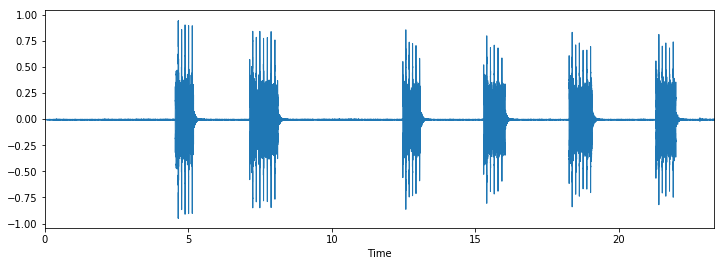

In [2]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

As we can see, this data set contains a long silence period, which would be 'alarm-off' section, several peak of them would be considered as 'alarm-on' section.


## 2.0 Data dividsion & aspect beyond wave


To train the network, we would need some labled data, which means we have to tell the system which sound is considered alarm on and which sound is considered alarm off, so, we divide the original dataset into two group: 'alarm on' and 'alarm off', because lack of data, we load the only one piece data into training & testing set seperatly.

Next, Let’s read some sound files and visualise to understand how different each sound clip is from other. Matplotlib’s specgram method performs all the required calculation and plotting of the spectrum. Likewise, Librosa provide handy method for wave and log power spectrogram plotting. By looking at the plots shown in Figure 1, 2, we can see apparent differences between different classes.

![aspect beyond wave](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/08/23212155/time_freq.png)

In [3]:
import sklearn.metrics
import librosa.display
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline

def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,30), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(6,1,i)
#         plt.figure(figsize=(12, 4))
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,30), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,30), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.core.amplitude_to_db(np.abs(librosa.stft(f))**2)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()



In [4]:
sound_file_paths = [
                    "/Users/dx/Documents/TF_sound_project/Sound-Data/train_1/alarm-1-0.wav",
                    "/Users/dx/Documents/TF_sound_project/Sound-Data/train_1/alarm-0-0.wav",
                   ]

sound_names = [
               "alarm_on",
               "alarm_off"
              ]

raw_sounds = load_sound_files(sound_file_paths)

plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)

## 3.0 Feature extraction & audio parsing

Feature Extraction
To extract the useful features from sound data, we will use Librosa library. It provides several methods to extract different features from the sound clips. We are going to use below mentioned methods to extract various features:

.melspectrogram: Compute a Mel-scaled power spectrogram

.mfcc: Mel-frequency cepstral coefficients

.chorma-stft: Compute a chromagram from a waveform or power spectrogram

.spectral_contrast: Compute spectral contrast

.tonnetz: Computes the tonal centroid features (tonnetz)


To make the process of feature extraction from sound clips easy, two helper methods are defined. First parse_audio_files which takes parent directory name, subdirectories within parent directory and file extension (default is .wav) as input. It then iterates over all the files within subdirectories and call second helper function extract_feature. It takes file path as input, read the file by calling librosa.load method, extract and return features discussed above. These two methods are all that is required to convert raw sound clips into informative features (along with a class label for each sound clip) that we can directly feed into our classifier. Remember, the class label of each sound clip is in the file name. For example, if the file name is alarm-1-0.wav then the class label will be 1. Doing string split by – and taking the second item of the array will give us the class label.


After that we use one hot encoder to encode different classes, by doing which it will elimite potential introduction of order bias into our dataset

![feature_extraction](https://image.slidesharecdn.com/musicclassificationatsoundcloud-140721050723-phpapp02/95/music-classification-at-soundcloud-20-638.jpg?cb=1405919546)

In [5]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[7].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [6]:
parent_dir = '/Users/dx/Documents/TF_sound_project/Sound-Data'
tr_sub_dirs = ['/Users/dx/Documents/TF_sound_project/Sound-Data/train_1','/Users/dx/Documents/TF_sound_project/Sound-Data/train_2']
ts_sub_dirs = ['/Users/dx/Documents/TF_sound_project/Sound-Data/test']
tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)
ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)

tr_labels = one_hot_encode(tr_labels)
ts_labels = one_hot_encode(ts_labels)

print('The training feature matrix is: ' + str(tr_features))
print('/n')
print('The training lable matrix is: ' + str(tr_labels))

The training feature matrix is: [[-4.27934753e+02 -6.56727295e+01 -7.67062330e+00 ... -8.66973281e-02
  -5.43601344e-02 -4.94509070e-02]
 [-4.27174500e+02 -6.49245300e+01 -7.09335613e+00 ... -3.73990923e-02
  -6.15067193e-02 -4.77250090e-02]
 [-6.26347717e+02  1.00105461e+02  2.55160675e+01 ... -6.82422582e-03
   4.00160269e-03 -1.04329683e-02]
 [-6.29005249e+02  9.91485596e+01  2.64674511e+01 ... -2.24890760e-02
   3.47712037e-03 -5.96426107e-03]
 [-4.15100586e+02 -7.53204956e+01 -6.22397518e+00 ... -6.89727138e-02
  -4.56833044e-02 -4.00277709e-02]
 [-6.26023193e+02  9.66286545e+01  2.71153812e+01 ...  2.60736669e-02
   1.64337286e-03 -2.67979902e-03]]
/n
The training lable matrix is: [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


## 4.0 Neural network build by Tensorflow

Now we have our training and testing set ready, let’s implement two layers neural network in Tensorflow to classify each sound clip into a different category.

The code provided below defines configuration parameters required by neural network model. Such as training epochs, a number of neurones in each hidden layer and learning rate.

In [7]:
training_epochs = 100
n_dim = tr_features.shape[1]
n_classes = 2
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

Now define placeholders for features and class labels, which tensor flow will fill with the data at runtime. Furthermore, define weights and biases for hidden and output layers of the network. For non-linearity, we use the sigmoid function in the first hidden layer and tanh in the second hidden layer. The output layer has softmax as non-linearity as we are dealing with multiclass classification problem.


Here is the approximatly structure of our neural network
![2_layer_neural_network](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [8]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

W0715 13:04:52.476524 4654577088 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


The cross-entropy cost function will be minimised using gradient descent optimizer, the code provided below initialize cost function and optimizer. Also, define and initialize variables for accuracy calculation of the prediction by model.

Gradient descent algoritm is classic, mature and highly-efficienct algorithm used in many AI networks today
![gradient_descent](https://miro.medium.com/max/1400/1*f9a162GhpMbiTVTAua_lLQ.png)

In [9]:
cost_function = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 5.0 Deep learning model training & accuracy test

We have all the required pieces in place. Now let’s train neural network model, visualise whether cost is decreasing with each epoch and make prediction on the test set, using following code:

Test accuracy:  1.0


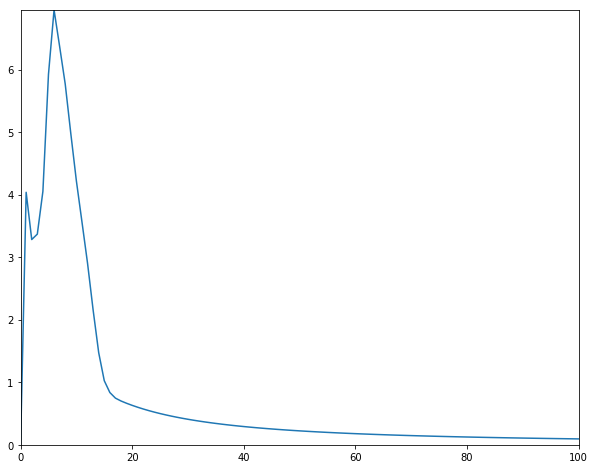

F-Score: 1.0


In [10]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:tr_features,Y:tr_labels})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: ts_features})
    y_true = sess.run(tf.argmax(ts_labels,1))
    print('Test accuracy: ',round(sess.run(accuracy, feed_dict={X: ts_features, Y: ts_labels}) , 3))

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='micro')
print ("F-Score:", round(f,3))

## 6.0 Develop a real-time detection system
now with the model ready, we can put in any vioce, then it will tell us wether the alarm is on or not, so we set up a little code which will repeat the following step:

1. record through microphone for 5 seconds
2. put the audio into the model, get the output
3. if the output is 1 (which means the alarm is on), turn on the alarm
4. if not, continue
5. repeat

now we got a real-time detection system which can constanlty monitor environmental audio then trigger the alarm if needed.

In [11]:
import pyaudio
import wave
 

In [12]:
def record_audio(record_seconds):
    
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 22050
    CHUNK = 1024
    RECORD_SECONDS = record_seconds
    WAVE_OUTPUT_FILENAME = "file.wav"
 
    audio = pyaudio.PyAudio()
    
    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)
    print("recording...")
    frames = []
 
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("finished recording")
 
 
    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()
 
    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()

In [13]:
def main():
    audio_file = ['/Users/dx/Documents/TF_sound_project/file.wav']
    i = 0
    while (i < 50):
        raw_sounds = load_sound_files(audio_file)
        parent_dir = sub_dirs = '/Users/dx/Documents/TF_sound_project/'
        features, labels = parse_audio_files(parent_dir, sub_dirs)
        with tf.Session() as sess:
            sess.run(init)
            y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: ts_features})
        print(y_pred)
        i = i+1
        

In [14]:
main()

[1 1]
[0 1]
[1 1]
[0 0]
[1 1]
[0 0]
[1 1]
[0 0]
[0 0]
[0 0]
[1 1]
[0 0]
[1 1]
[1 1]
[1 1]
[1 1]
[1 1]
[1 1]
[0 0]
[0 0]
[0 0]
[1 1]
[1 1]
[0 0]
[1 1]
[0 0]
[1 1]
[0 1]
[1 1]
[1 1]
[1 0]
[1 1]
[0 0]
[1 1]
[1 1]
[1 1]
[1 1]
[1 1]
[0 0]
[1 1]
[1 1]
[0 0]
[0 0]
[1 1]
[0 0]
[0 0]
[0 0]
[0 0]
[1 1]
[1 1]


## 7.0 next step

in the future we will use mutiple audio set to train our model, which makes it approach more accuracy and robust

Today is 14-Jul
thanks for looking at my little project!